In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import xgboost
import sys

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline



sys.path.append("C:\\Users\\isvys\\Projects\\nnboost\\")
from nnboost import NNBoostClassifier

# Pre-defined functions

In [2]:
def num_cat_split(df):
    '''returns list of numerical and categorical columns'''
    
    num_col = list(df.select_dtypes(include=['number']).columns)
    cat_col = list(set(df.columns) - set(num_col))

    print(f"Numerical columns : \n{num_col}")
    print("")
    print(f"Categorical columns :\n {cat_col}")
    
    return num_col, cat_col


def cabin_letter(x):
    if isinstance(x, str):
        return x[0]
    else:
        return str(np.nan)
    
def featuring(DF):
    DF.drop(['Name','PassengerId'], axis=1, inplace=True)
    DF['Cabin'] = DF['Cabin'].apply(cabin_letter)
#     DF['Age'] = np.log(DF['Age'])
    DF['Embarked'] = DF['Embarked'].str.upper()
    DF['Fare'] = DF['Fare'].apply(lambda x : 100 if x >=100 else x)
    DF['Parch'] = DF['Parch'].apply(lambda x : 2 if x >= 2 else x)
    DF['SibSp'] = DF['SibSp'].apply(lambda x : 2 if x >= 2 else x)
    
#     DF['Parch'] = DF['Parch'].astype('category')
#     DF['SibSp'] = DF['SibSp'].astype('category')
#     DF['Pclass'] = DF['Pclass'].astype('category')
    
    return DF.copy()

# 1. Load Data

In [3]:
DF = pd.read_csv('datasets/titanic_train.csv')
DF

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# 2. N/A Columns

In [4]:
p = 0.7 # columns with more than 30 n/a rows 
df_rows = DF.shape[0]
na_freq = DF.isna().sum().sort_values(ascending=False) / df_rows
na_freq = na_freq[na_freq > 0.3]

In [5]:
na_columns = na_freq.index

In [6]:
na_num_col, na_cat_col = num_cat_split(DF[na_columns])

Numerical columns : 
[]

Categorical columns :
 ['Cabin']


In [7]:
DF.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 3. Numerical Columns

In [8]:
num_col , _ = num_cat_split(DF)

Numerical columns : 
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical columns :
 ['Ticket', 'Sex', 'Name', 'Cabin', 'Embarked']


In [9]:
DF.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


[]

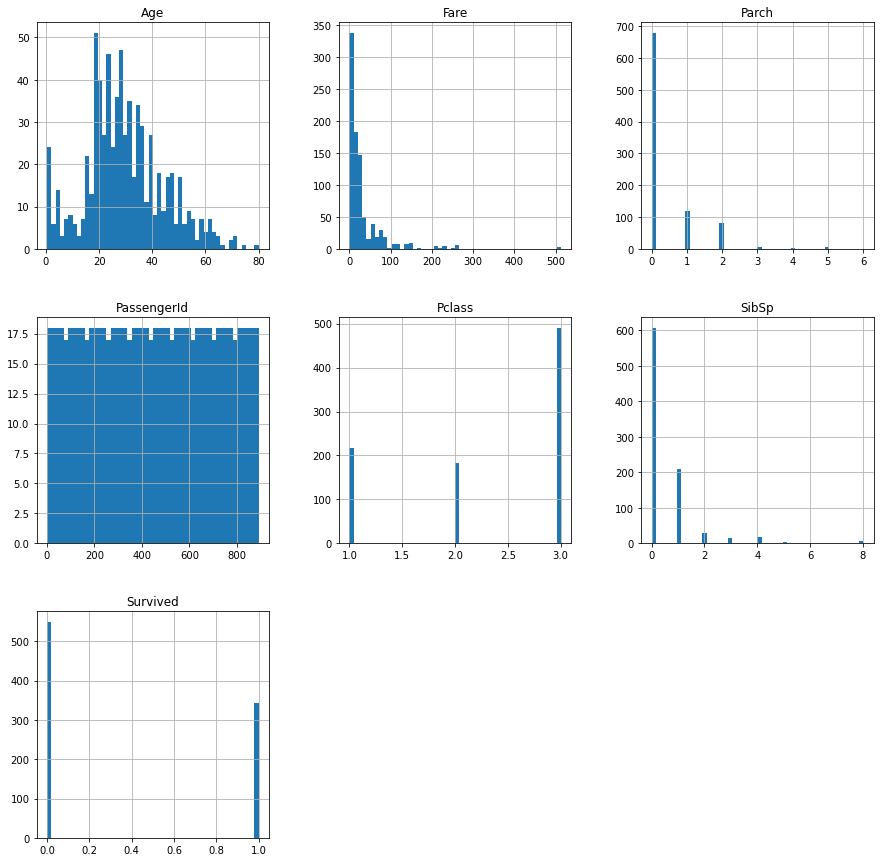

In [10]:
DF[num_col].hist(bins=50,figsize=(15,15))
plt.plot()

## 4. Categorical Columns

In [11]:
_ , cat_col = num_cat_split(DF)

Numerical columns : 
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical columns :
 ['Ticket', 'Sex', 'Name', 'Cabin', 'Embarked']


In [12]:
DF = featuring(DF)

In [13]:
DF

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,nan,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,nan,S
3,1,1,female,35.0,1,0,113803,53.1000,C,S
4,0,3,male,35.0,0,0,373450,8.0500,nan,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,nan,S
887,1,1,female,19.0,0,0,112053,30.0000,B,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,nan,S
889,1,1,male,26.0,0,0,111369,30.0000,C,C


In [14]:
X = DF.drop(['Survived'], axis=1).copy()
y = DF.Survived

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=77, stratify=y,)

In [33]:
num_col, cat_col = num_cat_split(X)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('numerical_imputer', SimpleImputer(strategy='median')),
    ('numerical_scaler', MinMaxScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('categorical_imputer', SimpleImputer(fill_value='NA', strategy='constant')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ])


Numerical columns : 
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical columns :
 ['Ticket', 'Cabin', 'Sex', 'Embarked']


In [34]:
model = NNBoostClassifier(n_estimators=2, learning_rate=0.1,seed=123)
# model = xgboost.XGBClassifier(learning_rate=0.2)

In [35]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [36]:
my_pipeline.fit(X_train,y_train)

NN #0 is done -> MAE : 0.03519478067755699
NN #1 is done -> MAE : 0.04251822084188461


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('numerical_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                   

In [37]:
preds = my_pipeline.predict(X_valid)

In [38]:
preds

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1], dtype=int64)

In [39]:
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       110
           1       0.82      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



In [41]:
X_test = pd.read_csv('datasets/titanic_test.csv')
Id = X_test['PassengerId']
X_test = featuring(X_test)
preds_test = my_pipeline.predict(X_test)
# Save test predictions to file
output = pd.DataFrame({'PassengerId': Id,
                       'Survived': preds_test})
output.to_csv('titanic_submission.csv', index=False)